<a href="https://colab.research.google.com/github/mohansharma18/Convolutional-Neural-Networks/blob/main/Melanoma_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Melanoma Assignment Problem Statement
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import PIL
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

### Loading Data

In [3]:

dataset_url = "https://drive.google.com/u/0/uc?id=1-gxPOBSlWP7S4zcNjE9iximvyDsjgxyz&export=download&confirm=t"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

823790659/823790659 [==============================] - 14s 0us/step


In [4]:
!mv  /root/.keras/datasets/'Skin cancer ISIC The International Skin Imaging Collaboration' /content/cancer_img
data_dir = pathlib.Path("/content/cancer_img").with_suffix('')

In [5]:
img_dir = list(data_dir.glob('*'))

In [6]:
# Assigning directory path of test and train

data_dir_train = img_dir[0]
data_dir_test = img_dir[1]

if img_dir[0].name in 'Test':
  data_dir_test = img_dir[0]
  data_dir_train = img_dir[1]

(data_dir_train,data_dir_test)

(PosixPath('/content/cancer_img/Train'), PosixPath('/content/cancer_img/Test'))

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Image Count",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Image Count",image_count_test)


Train Image Count 2239
Test Image Count 118


### Creating Train and validation dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Found 2239 files belonging to 9 classes.
{'actinic keratosis': ['/content/cancer_img/Train/actinic keratosis/ISIC_0031922.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0027650.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0026625.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0031108.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0033705.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029460.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0027802.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0025780.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029930.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0026626.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029915.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0028820.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0030344.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0026857.jpg', '/content/cancer_img/Train/actinic kerat

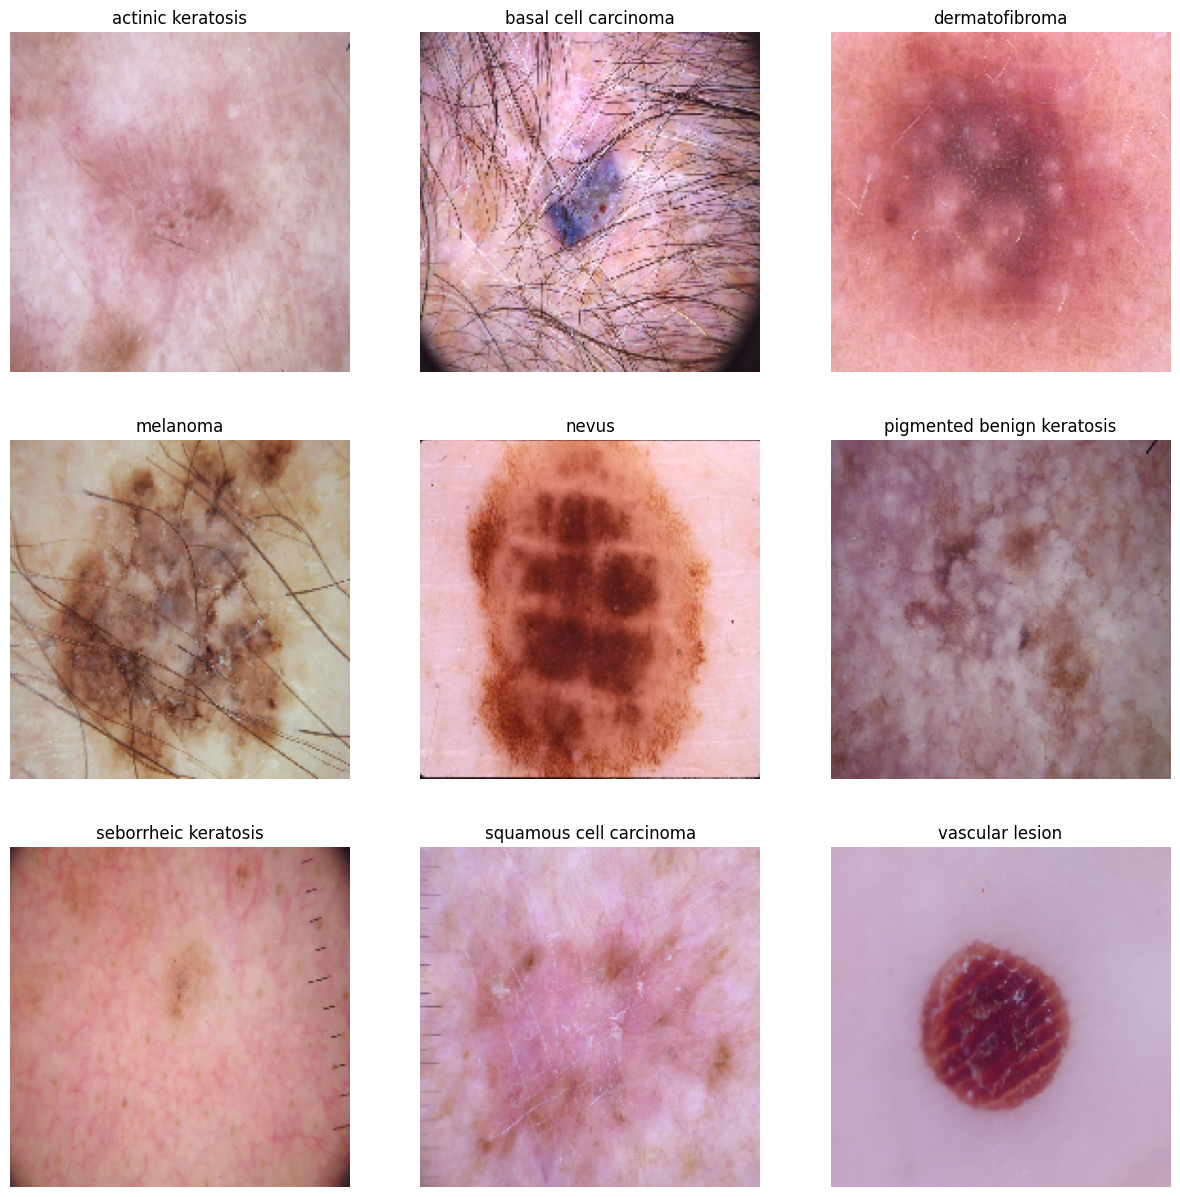

In [9]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

print(files_path_dict)
#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [10]:
class_map = {}
for k,v in files_path_dict.items():
  class_map[k]=len(v)
df = pd.DataFrame(list(class_map.items()),columns=['class','image_count'])
df

,class,image_count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='class', ylabel='image_count'>

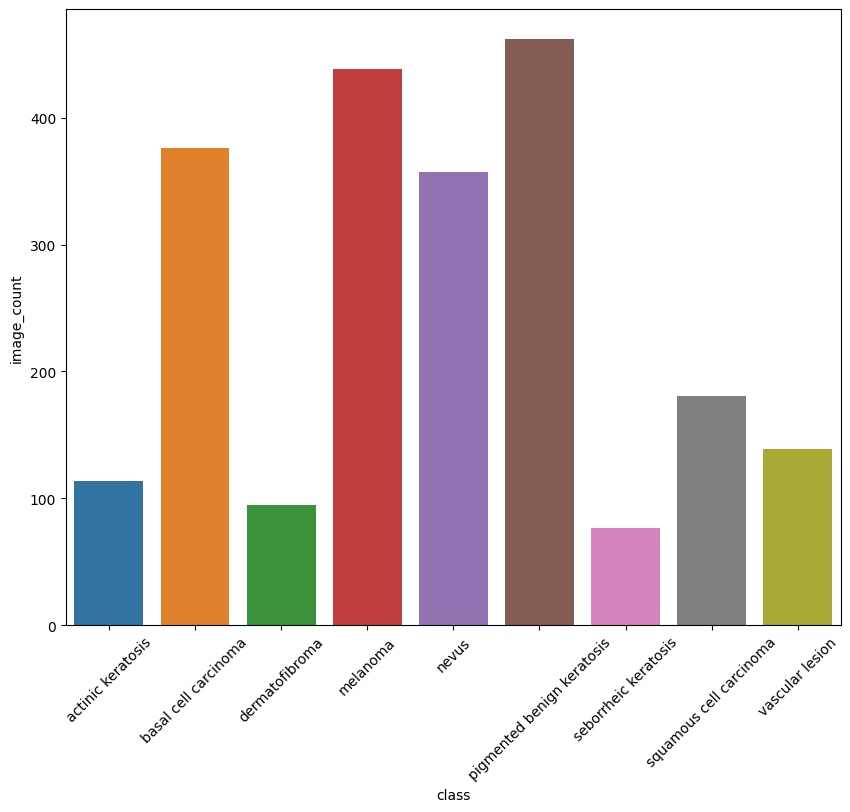

In [11]:
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45)

sns.barplot(x="class", y="image_count", data=df,
            label="Classes")


In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Creating model


In [14]:
class_names = train_ds.class_names
num_classes = len(class_names)
input_shape = (img_height,img_width,3)
(num_classes , input_shape )

(9, (180, 180, 3))

In [15]:
def execute_model(num_classes,mdl,optimizer='adam',loss='sparse_categorical_crossentropy',epochs=20):
  print("Settting Model Param for optimizer and loss ")
  model.compile(
  optimizer=optimizer,
  loss=loss ,
  metrics=['accuracy'])

  print("Model Summary")
  model.summary()

  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()



In [16]:
rescale_layer = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [17]:
# Creating Model with 3 Convulation Layer
model = Sequential()
model.add(rescale_layer)
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))



In [18]:
#execute_model(num_classes, model)

####
Model is Clearly Overfit , we can see the Training Accuracy keep rising, After epoch 5 we can see the validation starts falling or range bound below .55 to 0.48 range.
In the Loss Graph we can see that clearly , Loss increase a with increase in Epoch for training.

In [19]:
data_augmentation_layer = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

In [20]:
## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation_layer)             #Augmentation layer
model2.add(rescale_layer)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

In [21]:
#execute_model(num_classes, model2, optimizer='adam')

In [22]:
data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),

  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

In [25]:
def build_model(hp):
    # create model object
    model = Sequential([
        rescale_layer,
    #adding first convolutional layer
    Conv2D(
        #adding filter
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(img_height,img_height,3)),
        MaxPooling2D(pool_size = hp.Choice('conv_1_max_pooling', values = [2,3])),
        Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.25, step=0.5)),
    # adding second convolutional layer
    Conv2D(
        #adding filter
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    MaxPooling2D(pool_size = hp.Choice('conv_1_max_pooling', values = [2,3])),
    Dropout(hp.Float('conv_1_dropout', min_value=0.0, max_value=0.25, step=0.5)),

    # adding third convolutional layer
    Conv2D(
        #adding filter
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    MaxPooling2D(pool_size = hp.Choice('conv_3_max_pooling', values = [2,3])),
    Dropout(hp.Float('conv_3_dropout', min_value=0.0, max_value=0.25, step=0.5)),



    # adding flatten layer
    Flatten(),
    # adding dense layer
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer
    Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)

  # history = model.fit(
  # train_ds,
  # validation_data=val_ds,
  # epochs=epochs
  # )
# search best parameter
tuner.search(train_ds,epochs=5,validation_data=val_ds)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
112               |112               |conv_1_filter
5                 |5                 |conv_1_kernel
2                 |2                 |conv_1_max_pooling
0                 |0                 |conv_1_dropout
64                |64                |conv_2_filter
3                 |3                 |conv_2_kernel
32                |32                |conv_3_filter
5                 |5                 |conv_3_kernel
3                 |3                 |conv_3_max_pooling
0                 |0                 |conv_3_dropout
32                |32                |dense_1_units
0.001             |0.001             |learning_rate

Epoch 1/5
56/56 [==============================] - 458s 8s/step - loss: 2.1221 - accuracy: 0.1886 - val_loss: 2.0905 - val_accuracy: 0.1924
Epoch 2/5
24/56 [===========>..................] - ETA: 3:47 - loss: 2.0499 - accuracy: 0.2174

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model4 = tuner.hypermodel.build(best_hps)
history = model4.fit(train_ds, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_ds, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
!pip install Augmentor


In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [ ]:
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))